# Import libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.applications.resnet50 import ResNet50
from keras.models import Model
from pickle import dump,load
from keras.preprocessing.text import Tokenizer
import re

Using TensorFlow backend.
/Users/priya/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/priya/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/priya/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/priya/opt/anaconda3/lib/python3.7/sit

# Load the Captions in a dictionary

File **"Flickr8k.token.txt"** contains the captions of each image.<br>
There are 5 captions pee image.

In [3]:
# Read the tokens/descriptions into a file
text_file_path = "./data_1/text/Flickr8k.token.txt"
file = open(text_file_path, 'r')
text_file = file.read()

In [9]:
# Check whats there in text file

# Print fist 410 characters of the file.
print(text_file[:410])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .


Let's store these captions in a dictionary.

_Keys_ in dictionary will be each image_name or filename.<br>
_Values_ for each key will contain a list of 5 captions for that image.

In [11]:
# Create an empty dictionary
image_descriptions = {}

# Read the file line by line
for line in text_file.split('\n'):
    
    #Split by '#'
    key = line.split('#')
    
    #Split by 'tab'
    val = key[1].split('\t')
    
    # Check if key is already present or not in the dictionary
    if key[0] in image_descriptions.keys():
        
        #If key is present, then append to values
        image_descriptions[key[0]].append(val[1])
        
    else: 
        #Create a new key-value pair if key is not present
        image_descriptions[key[0]] = [val[1]]
        
# Check if all images/keys have 5 captions to them
for lines in image_descriptions.values():
    if len(lines)%5 !=0:
        print("Error: Number of captions for image {} are {}.".format(lines, len(lines)))
        
print('Dictionary created for captions!!!!!')

Dictionary created for captions!!!!!


# Let's get an idea what our data looks like.

Below function will print some images with their provided captions.

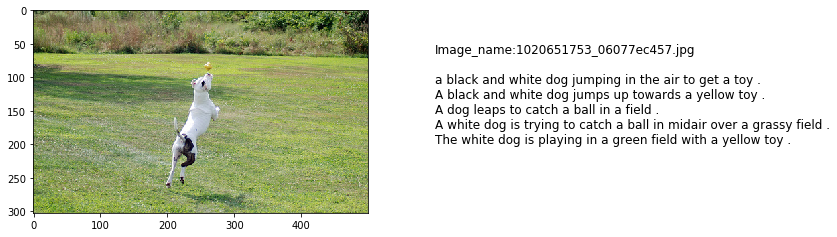

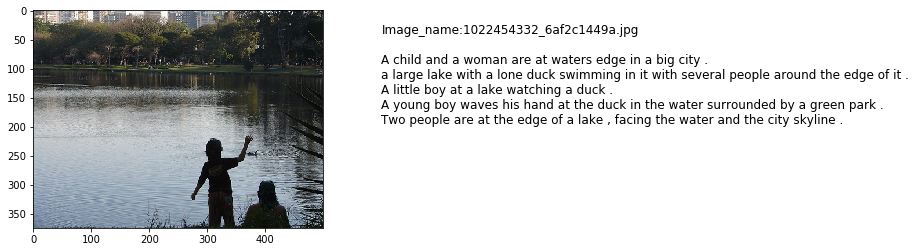

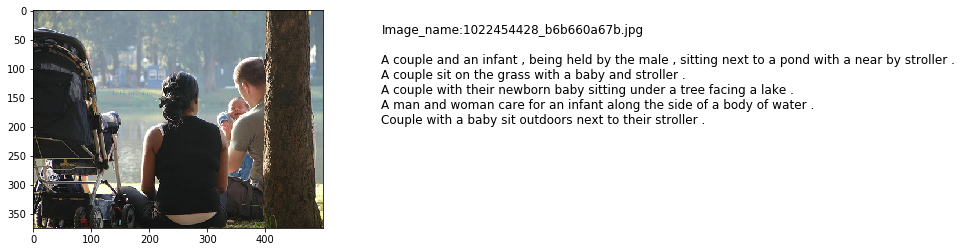

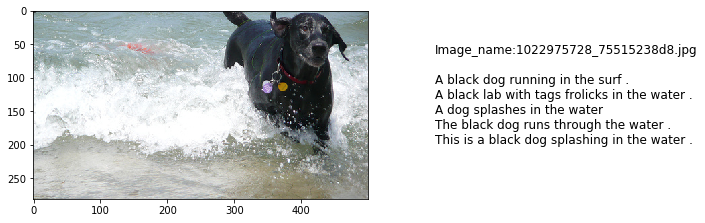

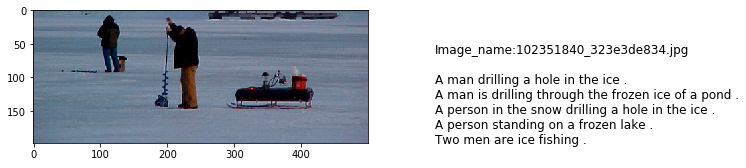

In [12]:
# provide the path where images are stored
path = './data_1/image/'

# Below outputs image_names from 15th to 19th element of dictionary
images = ({key:value for key,value in list(image_descriptions.items())[15:20]})

for key,value in images.items():
    filename = path+key
    s = ("Image_name:{}\n\n{}\n{}\n{}\n{}\n{}\n".format(key,value[0],value[1],value[2],value[3],value[4]))
    
    # Load the image
    image_load = load_img(filename)
    
    plt.imshow(image_load)
    plt.text(600, 220, s, fontsize=12)
    plt.show()

# Explore the length of captions

In [71]:
# List to store length of each caption
caption_length = []

for key,values in image_descriptions.items():
    for words in values:
        
        # Append the words in each caption
        caption_length.append(len(words.split()))
        
        # Below will print the captions with a single character length.
        if len(words.split())<2:
            print(key,values)
        

2428275562_4bde2bc5ea.jpg ['A', 'A black and white dog is climbing down a hill .', 'A black and white dog is sliding down a sandy hill .', 'A black and white dog wearing a red collar is digging in the dirt .', 'A black dog running on a sand mound .']
2833582518_074bef3ed6.jpg ['A dog running down a dirt track .', 'A greyhound running a race .', 'a muzzled greyhound dog is running around a track', 'Greyhound running on track with blue vest with a white numeral two .', 'The ']
3640443200_b8066f37f6.jpg ['a', 'A man dressed in a suit surrounded by formally dressed women with flowers', 'A man posing with four girls in formal attire , probably at a wedding .', 'Four bridesmaids posing dramatically with the groom .', 'Groom posing with bridesmaids .']


In [72]:
print("There are total {} words in descriptions.".format(len(caption_length)))

print("The minimum caption length is {}.".format(min(caption_length)))

print("The maximum caption length is {}.".format(max(caption_length)))

There are total 40460 words in descriptions.
The minimum caption length is 1.
The maximum caption length is 38.


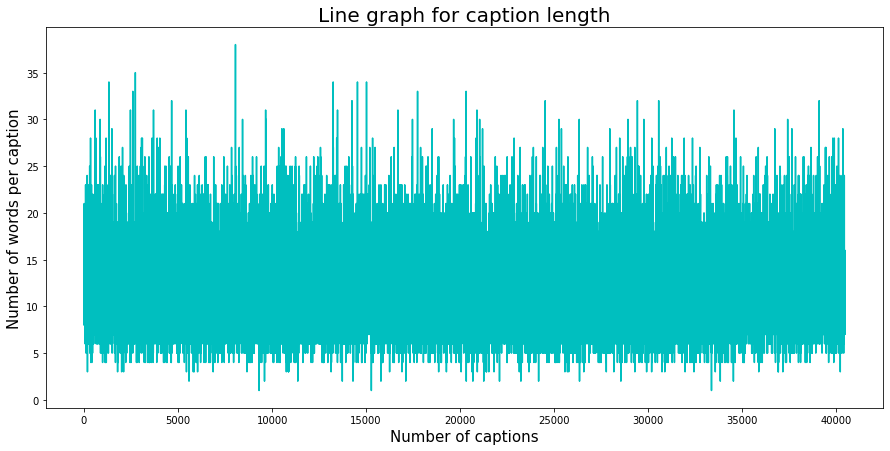

In [81]:
plt.figure(figsize=(15,7))
plt.plot(caption_length, color='c');
plt.title("Line graph for caption length",fontsize=20)
plt.xlabel("Number of captions",fontsize=15)
plt.ylabel("Number of words per caption",fontsize=15);
#plt.show()
#plt.hist(caption_length, color='c');

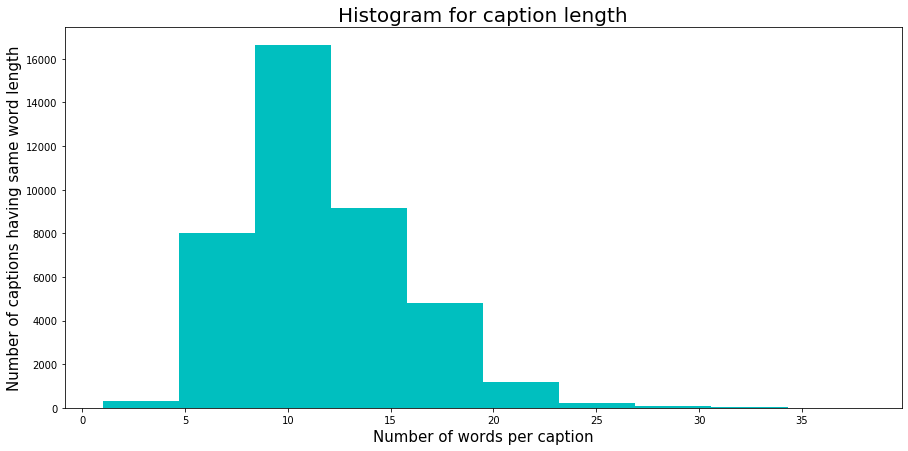

In [89]:
plt.figure(figsize=(15,7))
plt.hist(caption_length, color='c')
plt.title("Histogram for caption length",fontsize=20)
plt.ylabel("Number of captions having same word length",fontsize=15)
plt.xlabel("Number of words per caption",fontsize=15);

# Explore the text (captions)

We check if our data contains single characters like "A", "I" or if they contain any numbers like "1920s","20", etc.

By checking this, we will get an idea on how to clean our data.

In [13]:
# Create an empty dictionary to store words and their frequency
words_dict = {}

# Iterate through descriptions's values
for values in image_descriptions.values():
    for captions in values:
        for words in captions.split():
            if words in words_dict.keys():
                #If word is already present, increase the count
                words_dict[words] +=1
            else:
                # Add a new word to the dictionary key
                words_dict[words] = 1
                
print("Total unique words in captions are:  {}.\n".format(len(words_dict)))
                
print('Words with length less than 1 or with numbers are: ')

# Below will print the words which are intergers ar of character length =1
for k,v in words_dict.items():
    if (len(k) < 2) or ("1" in k):
        print(k,v)

Total unique words in captions are:  9627.

Words with length less than 1 or with numbers are: 
A 22667
a 40317
. 36570
, 3232
; 32
n 2
! 10
s 2
6 9
" 242
5 19
12 4
7 2
: 2
2 22
' 26
13406 1
4 16
3 17
I 13
8 13
m 1
17 1
19 3
( 6
) 4
c 1
? 9
P 2
104 2
i 3
V 1
21 2
1 2
11 2
& 5
o 2
O 2
13 3
U 1
- 2
h 1
281 2
X 2
v 1
661 1
157 1
10 1
1915 1
1923 1
1950s 1


# Clean the text(caption) data.

- Remove words with single character, like, "A", "n", "I"
- Remove punctuations like ".", "-"
- Remove the numbers like 1923, 1950s, etc.

In [14]:
# Function to clean the captions
def clean_descriptions(desc):
    
    image_descriptions_cleaned ={}
    
    for key,value in desc.items():
        captions = []

        for index in range(len(value)):
            lines = value[index]

            # Extract only words
            lines = re.sub(r'[^a-zA-Z\s]', '', lines.lower())

            words = [word for word in lines.split() if len(word)>1]

            sentences = ' '.join(words)

            captions.append(sentences)
        image_descriptions_cleaned[key] = captions

    return image_descriptions_cleaned

In [15]:
# Create a clean description dictionary which will be used later

image_descriptions_cleaned = clean_descriptions(image_descriptions)

In [16]:
# Create a cleaned words dictionary

words_dict_cleaned = {}
for values in image_descriptions_cleaned.values():
    for captions in values:
        for words in captions.split():
            if words in words_dict_cleaned.keys():
                words_dict_cleaned[words] +=1
            else:
                words_dict_cleaned[words] = 1
                
print("Total unique words in captions are (after cleaning):  {}.\n".format(len(words_dict_cleaned)))

Total unique words in captions are (after cleaning):  8764.



In [17]:
# Create a dataframe of cleaned words
words_df = pd.DataFrame([words_dict_cleaned]).T.reset_index()
words_df.columns=['word','count']

# Sort the words based on count and reset the index
words_df = words_df.sort_values('count',ascending=False).reset_index(drop=True)

#Print the first 5 lines
words_df.head()

,word,count
0,in,18973
1,the,18418
2,on,10742
3,is,9341
4,and,8851


In [18]:
#Print the last 5 lines
words_df.tail()

,word,count
8759,woolen,1
8760,poof,1
8761,needlepoint,1
8762,tending,1
8763,patterns,1


In [21]:
# How many words have length of 1.
words_df[words_df['count']==1]['word'].count()

3575

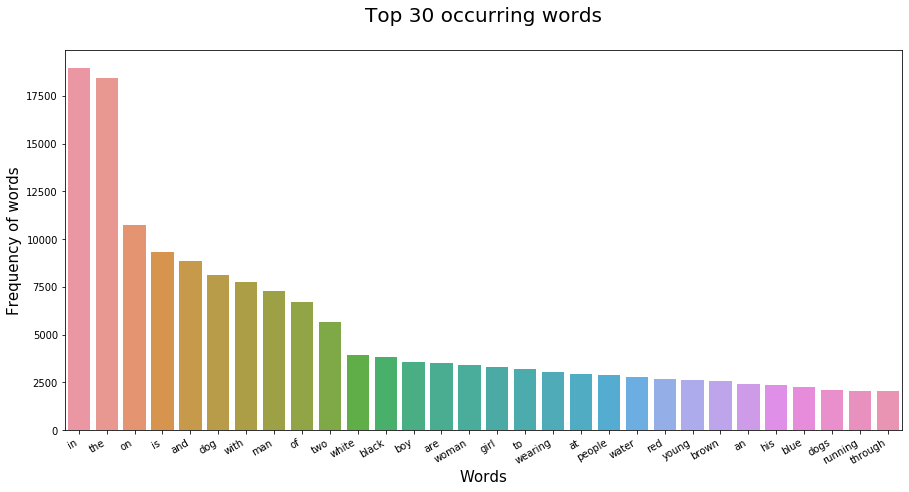

In [22]:
# Plot the words frequency
plt.figure(figsize=(15,7))
ax = sns.barplot(data=words_df[:30], x='word', y='count')
ax.set_xticklabels(ax.get_xticklabels(),rotation=30,horizontalalignment='right')
ax.set_xlabel("Words", fontsize=15)
ax.set_ylabel("Frequency of words", fontsize=15)
ax.set_title("Top 30 occurring words\n", fontsize=20);

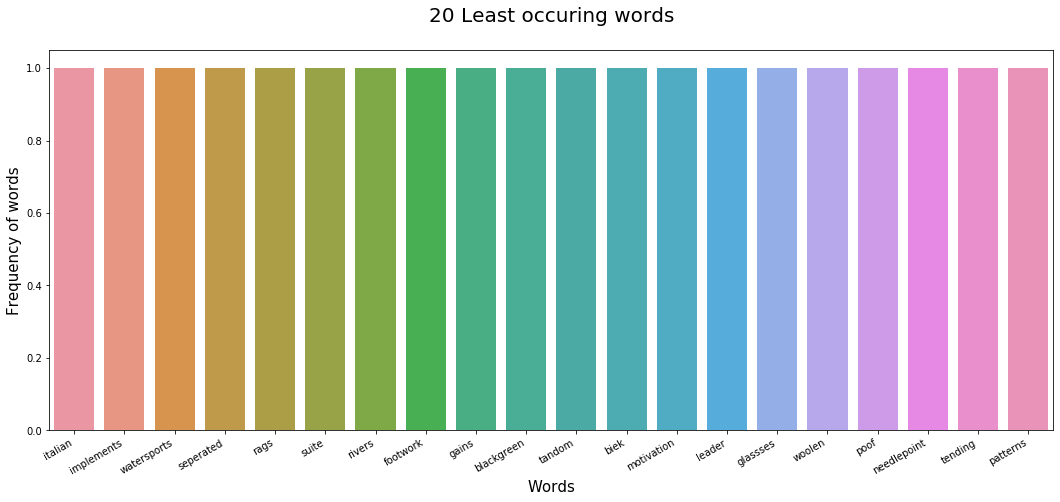

In [23]:
# Plot the words frequency
plt.figure(figsize=(18,7))
ax = sns.barplot(data=words_df[-20:], x='word', y='count')
ax.set_xticklabels(ax.get_xticklabels(),rotation=30,horizontalalignment='right')
ax.set_xlabel("Words", fontsize=15)
ax.set_ylabel("Frequency of words", fontsize=15)
ax.set_title("20 Least occuring words\n", fontsize=20);

# Load the train, dev and test filenames.

In [24]:
# Create a function to load the train and test image filenames

def load_files(path):
    open_file = open(path, 'r')
    read_file = open_file.read()
    
    image_name = []
    for images in read_file.split('\n'):
        image_name.append(images)
        
    return image_name

In [26]:
# Load the train files
train_files = load_files('./data_1/text/Flickr_8k.trainImages.txt')

print('There are {} train images.\n'.format(len(train_files)))
print('Sample image name from train_images: \n',train_files[:2])

There are 6000 train images.

Sample image name from train_images: 
 ['2513260012_03d33305cf.jpg', '2903617548_d3e38d7f88.jpg']


In [27]:
# Load the development files
dev_files = load_files('./data_1/text/Flickr_8k.devImages.txt')

print('There are {} development images.\n'.format(len(dev_files)))
print('Sample image name from development_images: \n',dev_files[:2])

There are 1000 development images.

Sample image name from development_images: 
 ['2090545563_a4e66ec76b.jpg', '3393035454_2d2370ffd4.jpg']


In [28]:
# Load the test files

test_files = load_files('./data_1/text/Flickr_8k.testImages.txt')

print('There are {} test images.\n'.format(len(test_files)))
print('Sample image name from test_images: \n',test_files[:2])

There are 1000 test images.

Sample image name from test_images: 
 ['3385593926_d3e9c21170.jpg', '2677656448_6b7e7702af.jpg']


## Add keywords like "startseq" & "endseq" for model to understand the start and end of a caption.

The model we will be developing will generate a caption for the provided photo. These captions will be generated one word at a time. <br>
The sequence of previously generated words will be provided as input. Therefore, we will need a ‘first word’ to kick-off the generation process and a ‘last word‘ to signal the end of the caption.

In [91]:
# Add the startseq & endseq for model to indicate that start/stop of actual text

def mod_descriptions(files):
    descriptions = {}
    
    for filenames in files:
        
        # create an empty list to store the modified captions
        image_captions = []
        
        # Iterate through the image name in image_descriptions
        if filenames in image_descriptions_cleaned.keys():
            
            # Iterate through values & append 'startseq' & 'endseq' to each caption
            for captions in range(len(image_descriptions_cleaned[filenames])):
                
                image_captions.append('startseq ' + image_descriptions_cleaned[filenames][captions] + ' endseq')
                
            descriptions[filenames] = image_captions
    return descriptions

In [92]:
# Extract the descriptions for train images
train_descriptions = mod_descriptions(train_files)

# Extract the descriptions for train images
dev_descriptions = mod_descriptions(dev_files)

# Extract the descriptions for test images
test_descriptions = mod_descriptions(test_files)

In [94]:
#See the 1st element of the dictionary: image_descriptions_cleaned
print({key:value for key,value in list(train_descriptions.items())[0:1]})

{'2513260012_03d33305cf.jpg': ['startseq black dog is running after white dog in the snow endseq', 'startseq black dog chasing brown dog through snow endseq', 'startseq two dogs chase each other across the snowy ground endseq', 'startseq two dogs play together in the snow endseq', 'startseq two dogs running through low lying body of water endseq']}


In [95]:
# Store the cleaned dictionary of descriptions

dump(train_descriptions,open("./saved_data/train_descriptions.pkl","wb"))
dump(test_descriptions,open("./saved_data/test_descriptions_.pkl","wb"))
dump(dev_descriptions,open("./saved_data/dev_descriptions.pkl","wb"))

In [4]:
# load the cleaned dictionary of descriptions

train_descriptions = load(open("./saved_data/train_descriptions.pkl","rb"))
dev_descriptions = load(open("./saved_data/dev_descriptions.pkl","rb"))
test_descriptions = load(open("./saved_data/test_descriptions.pkl","rb"))

# Prepare the image data

For computers to understand, we should be converting the image data into integers.

For this, I have used the pre-trained model like:
1. Inceptionv3
2. ResNet50

With the help of these pre-trained model, we can extract the "photo features" and use in our models.

**Extracting features from Inceptionv3 model**

In [74]:
# Instantiate the model
inception = InceptionV3(weights = 'imagenet',pooling="avg")

In [75]:
# Display what are the layers in the model
inception.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_10[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_442 (Activation)     (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
_______________________________________________________________________________________

**The output layer of this model is used for classification.<br>
But for image captioning, we will need to extract the features in an image, which will be done from the layer, just before the output layer.**

In [76]:
# Remove the output layer
inception.layers.pop()

In [77]:
# No training allowed for other layers
for layer in inception.layers:
   layer.trainable = False

In [78]:
# The shape of input layer
print(inception.layers[0].output,'\n')

# The shape of layer before output layer
print(inception.layers[-1].output)

Tensor("input_10:0", shape=(?, 299, 299, 3), dtype=float32) 

Tensor("avg_pool/Mean:0", shape=(?, 2048), dtype=float32)


In [79]:
# Define the model
inception_model = Model(input=inception.input,
                   output = inception.layers[-1].output)

/Users/priya/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("av...)`
  This is separate from the ipykernel package so we can avoid doing imports until


In [80]:
# Display the model summary
inception_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_10[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_442 (Activation)     (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [81]:
# Print the output shape of model
print(inception_model.output.shape)

(?, 2048)


In below function, we will extract the features from the images, by loading the images into the pre-trained and defined models.

In [97]:
# function to load the training images -- unhash later

def extract_features(model,path,file):
    
    # Create an empty dictionary to store the feature vector
    features = {}
    
    # Iterate through the file provided
    for key,value in file.items():
        
        # Define the image name
        image_name = path+key
        
        # Load the image
        # Target image size is different for Inception & ResNet models
        if model ==resnet_model:
            target_size = (224,224,3)   
        else:
            target_size = (299,299,3)
            
        image = load_img(image_name, target_size=target_size)

        # Convert to an array using Keras
        image_array = img_to_array(image)

        features_array = preprocess_input(image_array)

        features_array = np.expand_dims(features_array, axis=0)

        feature_vector = model.predict(features_array)
        
        if model ==resnet_model:
            feature_vector = feature_vector.squeeze() # reshape from (1, 2048) to (2048, )
            features[key] = feature_vector
            
        else:
            features[key] = np.reshape(feature_vector, feature_vector.shape[1]) # reshape from (1, 2048) to (2048, )        

    return features

In [84]:
# Extract the features for train and test images

# Provide the path where images are stored
path = './data_1/image/'

# Extract the features for train images
train_image_extracted_inception = extract_features(inception_model,path,train_descriptions)

# Extract the features for dev images
dev_image_extracted_inception = extract_features(inception_model,path,dev_descriptions)

# Extract the features for test images
test_image_extracted_inception = extract_features(inception_model,path,test_descriptions)

In [85]:
# Save the features, dictionary as an array. #unhash later

np.save('./saved_data/train_image_extracted_inception.npy', train_image_extracted_inception) 
np.save('./saved_data/dev_image_extracted_inception.npy', dev_image_extracted_inception) 
np.save('./saved_data/test_image_extracted_inception.npy', test_image_extracted_inception) 

In [8]:
# Load back the features.

train_image_extracted_inception = np.load('./saved_data/train_image_extracted_inception.npy',allow_pickle='TRUE').item()
dev_image_extracted_inception = np.load('./saved_data/dev_image_extracted_inception.npy',allow_pickle='TRUE').item()
test_image_extracted_inception = np.load('./saved_data/test_image_extracted_inception.npy',allow_pickle='TRUE').item()

**Extracting features from ResNet model**

In [98]:
# Instantiate the ResNet Model
resnet_model = ResNet50(weights='imagenet', pooling="max", input_shape=(224,224,3), include_top = False) 

# The shape of input layer
print(resnet_model.layers[0].output,'\n')

# The shape of layer before output layer
print(resnet_model.layers[-1].output)

# Print the model summary
print(resnet_model.summary())


Tensor("input_1:0", shape=(?, 224, 224, 3), dtype=float32) 

Tensor("global_max_pooling2d_1/Max:0", shape=(?, 2048), dtype=float32)
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256 

In [98]:
# Provide the path where images are stored
path = './data_1/image/'

# Extract the features for train images from ResNet model
train_image_extracted_resnet = extract_features(resnet_model,path,train_descriptions)

# Extract the features for dev images from ResNet model
dev_image_extracted_resnet = extract_features(resnet_model,path,dev_descriptions)

# Extract the features for test images from ResNet model
test_image_extracted_resnet = extract_features(resnet_model,path,test_descriptions)

In [93]:
# Save the features file
np.save('./saved_data/train_image_extracted_resnet.npy', train_image_extracted_resnet) 
np.save('./saved_data/dev_image_extracted_resnet.npy', dev_image_extracted_resnet) 
np.save('./saved_data/test_image_extracted_resnet.npy', test_image_extracted_resnet) 